In [ ]:
!pip install gensim
!pip install jieba
!pip install underthesea

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import jieba
import re

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/LDS0_K271_NGUYENMINHQUANG/Project3/'

/content/gdrive/MyDrive/LDS0_K271_NGUYENMINHQUANG/Project3


# Đọc dữ liệu

In [ ]:
products = pd.read_csv('Products.csv')
reviews = pd.read_csv('Reviews.csv', lineterminator='\n')

In [ ]:
products.head(2)

,item_id,name,description,rating,price,list_price,brand,group,url,image
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4373 entries, 0 to 4372
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      4373 non-null   int64  
 1   name         4373 non-null   object 
 2   description  4370 non-null   object 
 3   rating       4373 non-null   float64
 4   price        4373 non-null   int64  
 5   list_price   4373 non-null   int64  
 6   brand        4373 non-null   object 
 7   group        4373 non-null   object 
 8   url          4373 non-null   object 
 9   image        4373 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 341.8+ KB


# Underthesea

word_tokenize, pos_tag, sent_tokenize

  link: https://github.com/undertheseanlp/underthesea

In [ ]:
products = products[products['name'].notnull()]

In [ ]:
products['name_description'] = products.name + products.description

In [ ]:
products = products[products['name_description'].notnull()]

In [ ]:
products['name_description_pre'] = products['name_description'].apply(lambda x: word_tokenize(x, format='text'))

In [ ]:
type(products)

pandas.core.frame.DataFrame

In [ ]:
products.shape

(4370, 12)

In [ ]:
products.head(2)

,item_id,name,description,rating,price,list_price,brand,group,url,image,name_description,name_description_pre
0,48102821,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,THÔNG TIN CHI TIẾT\nDung lượng pin 300\nThời g...,4.0,77000,300000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-inpods-12-cam-bien-...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe Bluetooth Inpods 12 - Cảm biến vân ta...,Tai_nghe Bluetooth_Inpods 12 - Cảm_biến vân ta...
1,52333193,Tai nghe bluetooth không dây F9 True wireless ...,THÔNG TIN CHI TIẾT\nDung lượng pin 2000mah\nTh...,4.5,132000,750000,OEM,Thiết Bị Số - Phụ Kiện Số/Thiết Bị Âm Thanh và...,https://tai-nghe-bluetooth-khong-day-f9-true-w...,https://salt.tikicdn.com/cache/280x280/ts/prod...,Tai nghe bluetooth không dây F9 True wireless ...,Tai_nghe bluetooth không dây F9_True wireless ...


In [ ]:
products = products.reset_index()

In [ ]:
# Stop words
STOP_WORD_FILE = 'vietnamese-stopwords.txt'

In [ ]:
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = file.read()

stop_words = stop_words.split('\n')

In [ ]:
# TF - IFD
# tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words=stop_words)
tf = TfidfVectorizer(analyzer='word', min_df=0, stop_words=stop_words)

In [ ]:
tfidf_matrix = tf.fit_transform(products.name_description_pre)

# Consine Similarities

In [ ]:
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_similarities

array([[1.        , 0.40075346, 0.08112324, ..., 0.01782164, 0.01366667,
        0.06182976],
       [0.40075346, 1.        , 0.08310518, ..., 0.01635142, 0.0362413 ,
        0.09042972],
       [0.08112324, 0.08310518, 1.        , ..., 0.03441329, 0.03081951,
        0.06934047],
       ...,
       [0.01782164, 0.01635142, 0.03441329, ..., 1.        , 0.00868335,
        0.03151153],
       [0.01366667, 0.0362413 , 0.03081951, ..., 0.00868335, 1.        ,
        0.05662914],
       [0.06182976, 0.09042972, 0.06934047, ..., 0.03151153, 0.05662914,
        1.        ]])

In [ ]:
cosine_similarities.shape

(4370, 4370)

In [ ]:
# với mỗi sản phẩm, lấy 10 sản phẩm tương quan nhất
results = {}

for idx, row in products.iterrows():    
    similar_indices = cosine_similarities[idx].argsort()[:-10:-1]
    similar_items = [(cosine_similarities[idx][i],
                      products['item_id'][i]) for i in similar_indices]
    results[row['item_id']] = similar_items[1:]

In [ ]:
# các sản phẩm có tương quan với product_id = 38458616
results[38458616]

[(0.42237726870237413, 73314682),
 (0.42124676603061045, 74285829),
 (0.4028722356247838, 35373097),
 (0.38814945061946854, 26348659),
 (0.3870213799566182, 58291928),
 (0.37722761867485305, 48273751),
 (0.37634432549354524, 59130781),
 (0.3752756608519621, 72928043)]

In [ ]:
# Lấy thông tin sản phẩm
def item(id):
  return products.loc[products['item_id'] == id]['name'].to_list()[0].split('-')[0]

# Thông tin sản phẩm gợi ý
def recommend(item_id, num):
  print('Recommending ' + 
        str(num) + 
        ' products similar to ' + 
        item(item_id) + '...')
  print('* '*40)
  recs = results[item_id][:num]
  for rec in recs:
    print(rec[1])
    print('Recommended: product id:' + 
          str(rec[1]) + ', ' + 
          item(rec[1]) + '(score:' 
          + str(rec[0]) + ')')

In [ ]:
recommend(1059892, 5)

Recommending 5 products similar to Dây Cáp Sạc Lightning Cho iPhone Anker PowerLine II 0.9m ...
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
1060082
Recommended: product id:1060082, Dây Cáp Sạc Lightning Cho iPhone Anker PowerLine II 1.8m (score:0.7995292457852448)
3220143
Recommended: product id:3220143, Dây Cáp Sạc Lightning Cho iPhone Anker PowerLine+ 0.9m (Không Kèm Bao Da) (score:0.49636362486220253)
4028301
Recommended: product id:4028301, Dây cáp sạc Lightning cho iPhone iPad 1m (score:0.4951612453477318)
12485554
Recommended: product id:12485554, Bao da kiêm ốp lưng tự động tắt/mở màn hình thông minh dành cho ipad Mini 123/ Mini 4/ Ipad Air/ Ipad Air 2/ Ipad 234/ Ipad 2017/ Ipad 2018/ Ipad Pro 9.7(score:0.4254546812099706)
15682170
Recommended: product id:15682170, Dây Cáp Sạc USB(score:0.40709494226306286)


# Word cloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
def get_product_text(item_id, num):
  rcmd_ids = [r[1] for r in results[item_id]] + [item_id]
  text = (products[products.item_id.isin(rcmd_ids)])
  return ' '.join(text.name + text.description)

In [ ]:
wordcloud_text = get_product_text(1059892, 5)

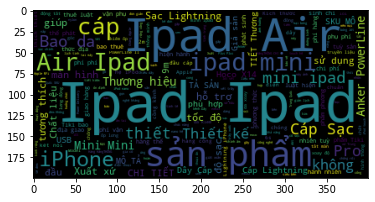

In [ ]:
wc = WordCloud(stopwords=stop_words).generate(wordcloud_text)
plt.imshow(wc)

▶ Nhận xét:
- Do sử dụng tên và phần mô tả để so sánh đặc tính của sản phẩm, độ chính xác của hệ thống không bị ảnh hưởng khi tên và phần mô tả không chính xác hoặc thiếu thông tin.

# Lưu kết quả

In [ ]:
info = []
for p_id, v in results.items():
  for item in v:
    info.append({
        'product_id':p_id,
        'rcmd_product_id':item[1],
        'score':item[0]
    })
content_based_df = pd.DataFrame(info)

In [ ]:
content_based_df.to_csv('CB.csv')